In [1]:
from pathlib import Path
import sys
sys.path.append('../')
from pma_open import *


#My image
file_path = '../Dropbox Files/hel1.pma'
image_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame.png"
image = io.imread(image_path, as_gray=True)

#Chanel image paths
CH1_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH1.png"
CH2_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH2.png"

good_peaks_1,_ = good_peak_finder(CH1_img_path)
good_peaks_2_new,_ = good_peak_finder(CH2_img_path, sigma=2, block_size=16, scaler_percent=10, boarder=10, max_rad=3)

# Move good_peaks_1 to CH2 to display full image
good_peaks_1_CH2 = shift_peaks(good_peaks_1)
good_peaks_2_CH2 = shift_peaks(good_peaks_2_new)

# Poly Mapping
CH1_peaks_10= np.array([[14, 190], [308, 10], [493, 131], [115, 168], [273, 61], [55, 59], [179, 41], [234, 157], [365, 161], [502, 43]])
CH2_peaks_10 = np.array([[18, 449], [311, 269], [492, 388], [119, 427], [276, 319], [60, 318], [183, 300], [236, 416], [364, 419], [501, 301]])

params_x_man_10, params_y_man_10 = find_polyfit_params(CH1_peaks_10, CH2_peaks_10, degree=3)
mapped_peaks_10 = apply_polyfit_params(good_peaks_1, params_x_man_10, params_y_man_10).astype(np.uint16)
poly_pair_count_tol4_10, poly_pair_arr_CH1_tol4_10, poly_pair_arr_CH2_tol4_10 = find_polyfit_pairs(mapped_peaks_10, good_peaks_1, tolerance=4)

In [2]:
# define key variables
y_centres_hel1 = np.concatenate((poly_pair_arr_CH1_tol4_10[:,0],poly_pair_arr_CH2_tol4_10[:,0]))
x_centres_hel1 = np.concatenate((poly_pair_arr_CH1_tol4_10[:,1],poly_pair_arr_CH2_tol4_10[:,1]))

circle_array = draw_circle(4, y_centres_hel1, x_centres_hel1, image.shape[0])
mask_new = (circle_array == [255, 255, 0]).all(axis=-1)
if image.ndim == 2:
    image_3d = np.repeat(image[..., np.newaxis], 3, -1)
elif image.ndim==3 and image.shape[2]==3:
    image_3d = image
image_3d[mask_new] = [255, 255, 0]

In [3]:
# def dynamic_global_background_subtraction(pma_file_path, input_array, radius, y_centre_arr, x_centre_arr):
#     frames_data = read_pma(pma_file_path) 
#     all_peaks_intensity = 0
#     corrected_frames_data = []
#     num_of_peaks = len(y_centre_arr)
#     num_of_peak_pixels = count_circle(radius) * num_of_peaks
#     num_of_frame_pixels = input_array.shape[0] * input_array.shape[1]
#     #filling in the circle
#     for frame in frames_data: #frame is 1D
#         for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
#             for i in range(x_centre - radius, x_centre+ radius + 1):
#                 for j in range(y_centre - radius, y_centre + radius + 1):
#                     if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
#                         all_peaks_intensity += int(input_array[i][j][0])
        
#         # by summing the third column of the array we exclude the yellow pixels from being included!
#         total_intensity = np.sum(input_array[:, :,2])
#         #avg_peak_intensity gives the avg intensity of the pixels that are not within the yellow circle
#         intensity_to_remove = (total_intensity-all_peaks_intensity) // (num_of_frame_pixels-num_of_peak_pixels)
#         frame = frame.astype(np.int8)
#         frame = np.clip(frame - intensity_to_remove, 0, 255)
#         corrected_frames_data.append(frame)

#     return corrected_frames_data

In [4]:
Frames_data = read_pma(file_path)
print(f"Frames_data type: {type(Frames_data)}")
print(f"Frames_data[0] Shape: {Frames_data[0].shape}")
print(f"Frames_data element type: {type(Frames_data[0][0][0])}\n")

corrected_frames_data = dynamic_global_background_subtraction(file_path, image_3d, 4, y_centres_hel1, x_centres_hel1)
print(f"Corrected Frames_data type: {type(corrected_frames_data)}")
print(f"Corrected Frames_data[0] shape: {corrected_frames_data[0].shape}")
print(f"Corrected Frames_data element type: {type(corrected_frames_data[0][0][0])}")

Image Size: 512 x 512
Frames_data type: <class 'list'>
Frames_data[0] Shape: (512, 512)
Frames_data element type: <class 'numpy.uint8'>

Image Size: 512 x 512


/var/folders/r0/qp6_p2111v1dzb0fg2bbfqsr0000gn/T/ipykernel_91127/1039063178.py:19: RuntimeWarning: overflow encountered in scalar subtract
  intensity_to_remove = (total_intensity-all_peaks_intensity) // (num_of_frame_pixels-num_of_peak_pixels)


Corrected Frames_data type: <class 'list'>
Corrected Frames_data[0] shape: (512, 512)
Corrected Frames_data element type: <class 'numpy.float64'>


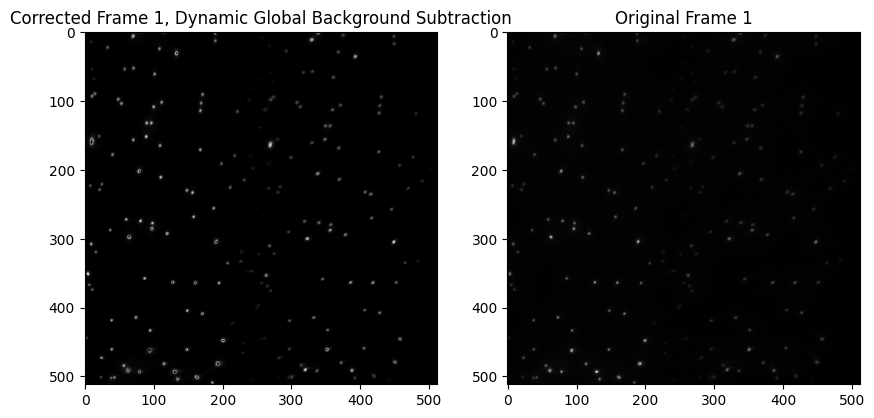

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(corrected_frames_data[0], cmap='gray')
ax[0].set_title('Corrected Frame 1, Dynamic Global Background Subtraction')

ax[1].imshow(Frames_data[0], cmap='gray')
ax[1].set_title('Original Frame 1')
plt.show()

In [6]:
print(Frames_data[0][0][:5])
print(corrected_frames_data[0][0][:5])

[7 6 7 6 6]
[0. 0. 0. 0. 0.]
